In [1]:
import json
import re
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import string
import nltk
import numpy as np 
import pandas as pd
import xgboost as xgb
%matplotlib inline
from textblob import Word
from math import sqrt
from functools import reduce
from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
from nltk.corpus import stopwords
import matplotlib.path as mplPath
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import utils
from sklearn.metrics import accuracy_score
import collections 
from nltk import word_tokenize, pos_tag  
from scipy.sparse import hstack

In [2]:
player=pd.read_csv("Player.csv",encoding="ISO-8859-1")
match=pd.read_csv("Match.csv",encoding="ISO-8859-1")
team=pd.read_csv("Team.csv",encoding="ISO-8859-1")
ball_by_ball=pd.read_csv("Ball_By_Ball.csv",encoding="ISO-8859-1")
palayer_match=pd.read_csv("Player_match.csv",encoding="ISO-8859-1")

In [3]:
ball_by_ball.MatcH_id.value_counts()
ball_by_ball.Striker_Batting_Position.fillna(4,inplace=True)

In [4]:
ball_by_ball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150451 entries, 0 to 150450
Data columns (total 48 columns):
MatcH_id                    150451 non-null int64
Over_id                     150451 non-null int64
Ball_id                     150451 non-null int64
Innings_No                  150451 non-null int64
Team_Batting                150451 non-null object
Team_Bowling                150451 non-null object
Striker_Batting_Position    150451 non-null float64
Extra_Type                  150451 non-null object
Runs_Scored                 150451 non-null int64
Extra_runs                  150451 non-null int64
Wides                       150451 non-null int64
Legbyes                     150451 non-null int64
Byes                        150451 non-null int64
Noballs                     150451 non-null int64
Penalty                     150451 non-null int64
Bowler_Extras               150451 non-null int64
Out_type                    150451 non-null object
Caught                      15045

In [5]:
ball_by_ball.Player_Out.fillna(value=0, inplace=True)

In [6]:
# ball_by_ball.Player_Out

In [7]:
features=["MatcH_id","Over_id","Innings_No","Runs_Scored","Extra_runs"]

In [8]:
data=ball_by_ball[features]

In [9]:
data['id'] = data['MatcH_id'].apply(str)+","+data['Innings_No'].apply(str)+","+data['Over_id'].apply(str)
data = pd.DataFrame(data[['id','Runs_Scored',"Extra_runs"]].groupby('id').sum())
data

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Runs_Scored,Extra_runs
id,,
"1082591,1,1",4,3
"1082591,1,10",4,0
"1082591,1,11",10,0
"1082591,1,12",8,0
"1082591,1,13",17,1
"1082591,1,14",8,0
"1082591,1,15",19,0
"1082591,1,16",4,0
"1082591,1,17",7,0


In [10]:
def bowler(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'Bowler']
    return(a[a.index[0]])

In [11]:
data['id'] = data.index
data["Bowler"]=data.id.apply(lambda x:bowler(x))
# str(ball_by_ball.MatcH_id)=='981024'

In [12]:
# ball_by_ball.Striker.value_counts()

In [13]:
def striker(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'Striker']
    return(a[a.index[0]])

In [14]:
data['id'] = data.index
data["Striker"]=data.id.apply(lambda x:striker(x))
# str(ball_by_ball.MatcH_id)=='981024'

In [15]:
def Striker_Batting_Position(x):
    ok=x.split(",")
    a=ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'Striker_Batting_Position']
#     print(int(ok[2]))
    return(a[a.index[0]])

In [16]:
data["strike_position"]=data.id.apply(lambda x:Striker_Batting_Position(x))

In [17]:
# a=ball_by_ball.loc[ball_by_ball.Innings_No==2,'Striker_Batting_Position']
# print(a)
ball_by_ball.MatcH_id

0         598028
1         598028
2         598028
3         598028
4         598028
5         598028
6         598028
7         598028
8         598028
9         598028
10        598028
11        598028
12        598028
13        598028
14        598028
15        598028
16        598028
17        598028
18        598028
19        598028
20        598028
21        598028
22        598028
23        598028
24        598028
25        598028
26        598028
27        598028
28        598028
29        598028
           ...  
150421    598028
150422    598028
150423    598028
150424    598028
150425    598028
150426    598028
150427    598028
150428    598028
150429    598028
150430    598028
150431    598028
150432    598028
150433    598028
150434    598028
150435    598028
150436    598028
150437    598028
150438    598028
150439    598028
150440    598028
150441    598028
150442    598028
150443    598028
150444    598028
150445    598028
150446    598028
150447    598028
150448    5980

In [18]:
# a=ball_by_ball.Striker_Batting_Position
ball_by_ball.Striker_Batting_Position.isnull().sum()

0

In [19]:
player.head()

,PLAYER_SK,Player_Id,Player_Name,DOB,Batting_hand,Bowling_skill,Country_Name
0,0,1,SC Ganguly,7/8/1972,Left-hand bat,Right-arm medium,India
1,1,2,BB McCullum,9/27/1981,Right-hand bat,Right-arm medium,New Zealand
2,2,3,RT Ponting,12/19/1974,Right-hand bat,Right-arm medium,Australia
3,3,4,DJ Hussey,7/15/1977,Right-hand bat,Right-arm offbreak,Australia
4,4,5,Mohammad Hafeez,10/17/1980,Right-hand bat,Right-arm offbreak,Pakistan


In [20]:
def PlayerOut(x):
    ok=x.split(",")
    mid= int(ok[0])
    iid=int(ok[1])
    oid=int(ok[2])
    if(oid==1):
        return 0
    else:
        a=ball_by_ball.loc[(ball_by_ball.MatcH_id==mid)&(ball_by_ball.Innings_No==iid)&(ball_by_ball.Over_id==oid-1),'Player_Out']
        count=0
        for i in a:
            if(i!=0):
                count+=1
        return(count)

In [21]:
data["playerout"]=data.id.apply(lambda x:PlayerOut(x))

In [22]:
def MatchDateSK(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'MatchDateSK']
    return(max(a))

In [23]:
data['matchdatesk']=data.id.apply(lambda x:MatchDateSK(x))

In [24]:
def BattingTeamSK(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'BattingTeam_SK']
    return(max(a))

In [25]:
def BowlingTeamSK(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'BowlingTeam_SK']
    return(max(a))

In [26]:
data['bowlingteamsk']=data.id.apply(lambda x:BowlingTeamSK(x))

In [27]:
data['battingteamsk']=data.id.apply(lambda x:BattingTeamSK(x))

In [28]:
def MatchDate(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'Match_Date']
    return(max(a))

In [ ]:
data["matchdate"]=data.id.apply(lambda x:MatchDate(x))
data['total_runs']=data['Runs_Scored']+data['Extra_runs']
data['high_runs']=data['total_runs']>=12

In [ ]:
bat_skill = data.groupby(['Striker', 'high_runs'])['Striker'].count().unstack('high_runs').fillna(0)
bat_skill["sum"]=bat_skill[True]+bat_skill[False]
bat_skill['Striker'] = bat_skill.index
dict=bat_skill.to_dict()
def bat_skill(x):
    return dict[True][x]
data['bat_skill']=data['Striker'].apply(bat_skill)

In [ ]:
def experience(x):
    return dict["sum"][x]
data['bat_Experience']=data['Striker'].apply(experience)

In [ ]:
# bowl_skill = data.groupby(['Bowler', 'playerout'])['Bowler'].count().unstack('playerout').fillna(0)
# #bowl_skill["sum"]=bat_skill[True]+bat_skill[False]
# bowl_skill['Bowler'] = bat_skill.index
# #dict=bowl_skill.to_dict()
# #def bat_skill(x):
# #   return dict[True][x]
# #data['bat_skill']=data['Striker'].apply(bat_skill)
# bowl_skill.loc[

In [ ]:
def year(x):
    a=x.split("/")
    if(a[2]=='2017'):
        return 1
    else :
        return 0
data["is2017"]=data.matchdate.apply(lambda x:year(x))


In [ ]:
def year1(x):
    a=x.split("/")
    if(a[2]=='2013'):
        return 1
    else :
        return 0
data["2013"]=data.matchdate.apply(lambda x:year1(x))
data2013=data[data['2013']==1]
data2013srh=data2013[data2013['bowlingteamsk']==10]
data2013srhrps=data2013srh[data2013srh['battingteamsk']==9]


In [ ]:
def over(x):
    tok=x.split(",")
    return int(tok[2])

data["over"]=data.id.apply(lambda x:over(x))

In [ ]:
data.to_csv("ProcessedData.csv")

In [ ]:
from sklearn.utils import shuffle
data = shuffle(data)


In [ ]:
data.head()

In [ ]:
train=data[data.is2017==0]

In [ ]:
test=data[data.is2017==1]

In [ ]:
rpo = pd.DataFrame(data[['over','total_runs']].groupby('over').sum())
rpo['over'] = rpo.index
rpo.plot(kind="bar",x='over',figsize=(10,5))

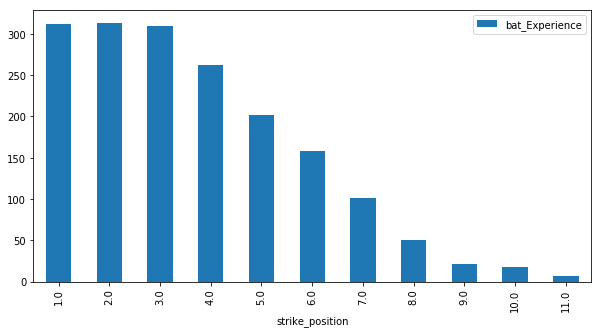

In [53]:
sto = pd.DataFrame(data[['strike_position','bat_Experience']].groupby('strike_position').mean())
sto['strike_position'] = sto.index
sto.plot(kind="bar",x='strike_position',figsize=(10,5))

In [ ]:
test.info()

In [ ]:
num_feats = ["strike_position","playerout","over","bat_skill","bat_Experience"
            ]
# "distance" "contact"
X = train[num_feats]
y = train["high_runs"]
x_val = test[num_feats]
y_val = test['high_runs']

In [ ]:
import xgboost as xgb
clf1 = xgb.XGBClassifier(n_jobs=-2)
clf1.fit(X, y)

In [ ]:
y_pred = clf1.predict(x_val)
accuracy_score(y_val,y_pred)

In [ ]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(30,20))
plt.title('Feature ranking', fontsize = 18)
plt.ylabel('Importance degree', fontsize = 13)
# plt.xlabel("Features", fontsize = 14)

feature_names = num_feats
plt.xticks(range(len(num_feats)), feature_names, fontsize = 15)
plt.bar(range(len(clf1.feature_importances_)), clf1.feature_importances_)